## License 

Copyright 2017 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

#### Python imports

In [1]:
# sklearn for single DT
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # for LIME

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

pd.options.display.max_columns = 999 # enable display of all columns in notebook

# plotting functionality
#import matplotlib.pyplot as plt

import shap # Python Shapley value package

# system packages for calling external graphviz processes
import os
import re
import subprocess

import operator # for sorting dictionaries

# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

/home/patrickh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. Load Data

#### Import data and clean

In [2]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

In [3]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID', 'AGE', 'EDUCATION', 'SEX', 'MARRIAGE', 'LIMIT_BAL']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics

In [4]:
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


#### Split data into training and test sets for early stopping

In [5]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


# 2. Train Single Decision Tree

#### Train DT classifier

In [6]:
clf = DecisionTreeClassifier(random_state=12345, max_depth=3)
clf.fit(train[X].values, train[y].values)
sklearn.tree.export_graphviz(clf, 'model.gv', feature_names=X, proportion=True)

#### Test AUC

In [7]:
roc_auc_score(test[y].values, clf.predict_proba(test[X].values)[:, 1])

0.7391279135043209

#### Create PNG from GraphViz dot file

In [8]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_args = str('dot -Tpng model.gv -o model.png')
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng model.gv -o model.png


# 3. Visualize and Explain Single Tree

#### Display tree

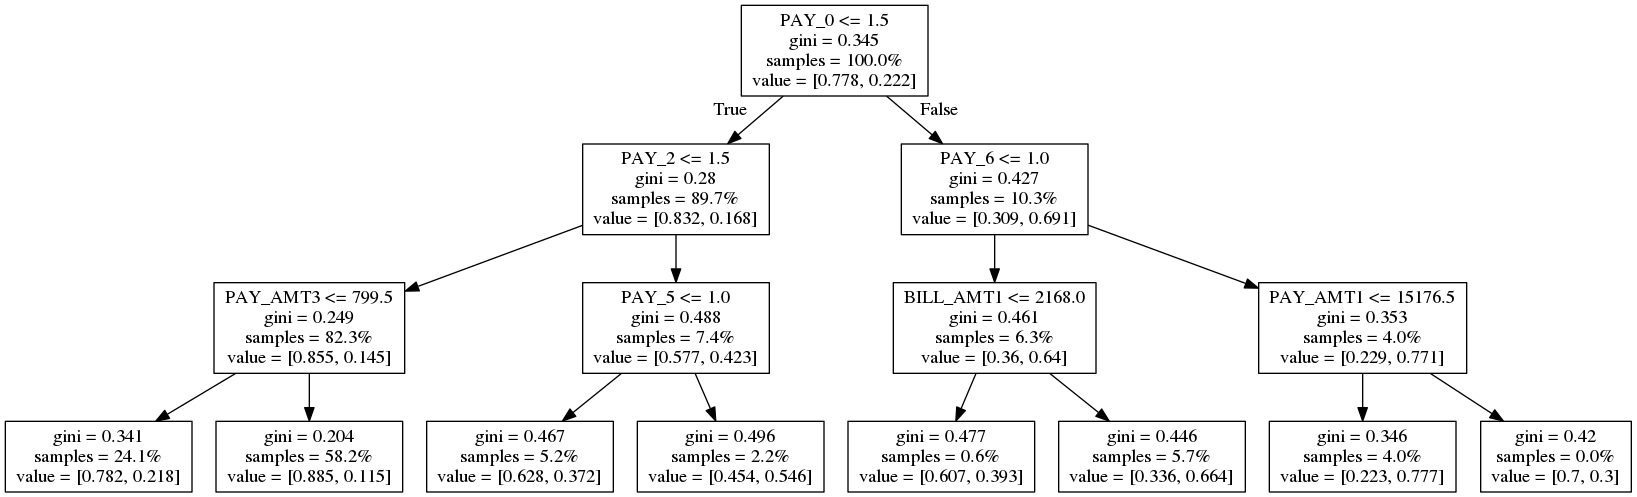

In [9]:
# display in-notebook
display(Image(('model.png')))

#### Display global Shapley variable importance

 98%|===================| 17711/18108 [00:14<00:00]        

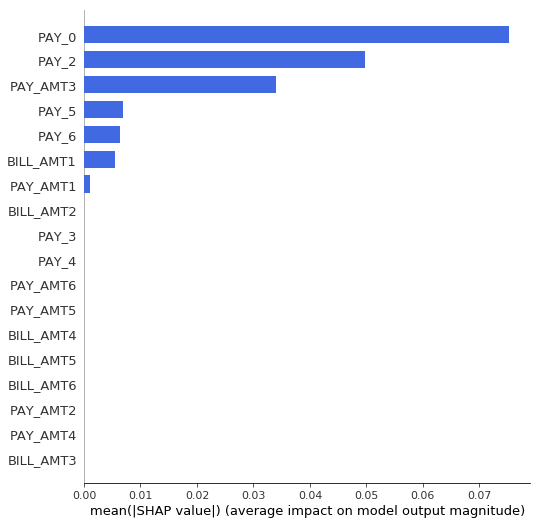

In [10]:
explainer = shap.TreeExplainer(clf, test[X], model_output='probability', feature_dependence='independent')
shap_values = explainer.shap_values(test[X].values)
shap.summary_plot(shap_values[1], X, plot_type='bar', color='royalblue')

#### Find riskiest customer

In [11]:
yhat = 'p_DEFAULT_NEXT_MONTH'
test[yhat] = clf.predict_proba(test[X].values)[:, 1]
test.reset_index(inplace=True, drop=True)
test.sort_values(by=yhat, inplace=True)
id_ = test.iloc[-1, :].loc['ID']
idx = test.iloc[-1, :].name
pd.DataFrame(test.iloc[-1, :])

/home/patrickh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/patrickh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,4445
ID,14563.000000
LIMIT_BAL,240000.000000
SEX,2.000000
EDUCATION,2.000000
MARRIAGE,1.000000
AGE,39.000000
PAY_0,4.000000
PAY_2,3.000000
PAY_3,2.000000
PAY_4,2.000000


#### Display local Shapley values for the riskiest customer predictions

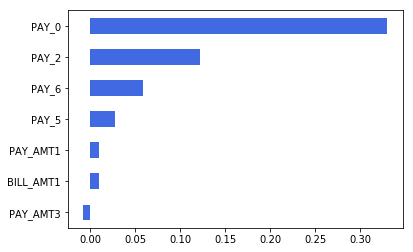

In [19]:
s_df = pd.DataFrame(shap_values[1][idx, :], index=X)
s_df.sort_values(by=0, inplace=True)
_ = s_df[s_df[0] != 0].plot(kind='barh' , color='royalblue', legend=False)

#### Check Shapley sum

In [13]:
s_df.sum()[0] + explainer.expected_value[1]

0.7771084197639089

#### Approximate LIME trends

In [14]:
local = test[(test['PAY_0'] > 1.5)]
local_X = s_df[s_df[0] != 0].index

h2o.init()

local = h2o.H2OFrame(local)
local['PAY_0'] = local['PAY_0'].asfactor()
local['PAY_2'] = local['PAY_2'].asfactor()
local['PAY_5'] = local['PAY_5'].asfactor()
local['PAY_6'] = local['PAY_6'].asfactor()

# initialize
local_glm = H2OGeneralizedLinearEstimator(lambda_search=True, seed=12345)

# train 
local_glm.train(x=list(local_X), y=yhat, training_frame=local)

# coefs
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))
        
# r2
print('\nLocal GLM R-square:\n%.6f' % local_glm.r2())

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_201"; Java(TM) SE Runtime Environment (build 1.8.0_201-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjpm7pzq6
  JVM stdout: /tmp/tmpjpm7pzq6/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpjpm7pzq6/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,20 days
H2O cluster name:,H2O_from_python_patrickh_435eyy
H2O cluster total nodes:,1
H2O cluster free memory:,3.422 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%

Local GLM Coefficients:
PAY_6.-1:                 -0.18178449655001785
PAY_2.-1:                 -0.14299724067347283
PAY_6.-2:                 -0.12477348565333289
PAY_6.0:                  -0.11555612541709302
PAY_5.-1:                 -0.02764077237891427
PAY_5.-2:                 -0.019940748847883594
PAY_2.2:                  -0.0024667856635693115
PAY_0.3:                  -0.002358539123788783
PAY_5.2:                  -0.0005538556971602666
PAY_AMT3:                 -5.86716289798128e-07
BILL_AMT1:                3.433893789444963e-08
PAY_AMT1:                 4.806161776083594e-07
PAY_0.4:                  0.0008928696129156811
PAY_2.4:                  0.0010890792598825059
PAY_5.3:                  0.0017246840049273081
PAY_6.2:                  0.0035605853689740837
PAY_0.5:                  0.004290344886079893
P

#### Assess LIME prediction accuracy for row of interest

In [15]:
local_glm.predict(local[local['ID'] == id_])

glm prediction progress: |████████████████████████████████████████████████| 100%


predict
0.77959


#### Visually assess LIME model fit

glm prediction progress: |████████████████████████████████████████████████| 100%


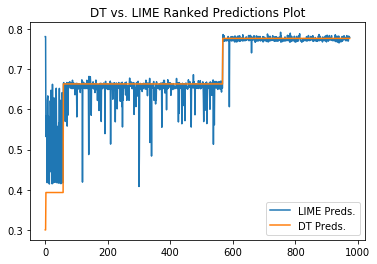

In [16]:
# ranked predictions plot
pred_frame = local_glm.predict(local).cbind(local)\
                       .as_data_frame()[['predict', yhat]]
pred_frame.columns = ['LIME Preds.', 'DT Preds.']
pred_frame.sort_values(by='DT Preds.', inplace=True)
pred_frame.reset_index(inplace=True, drop=True)
_ = pred_frame.plot(title='DT vs. LIME Ranked Predictions Plot')